Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [486]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [487]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [488]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak/Maize_yield_1970_2013'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'

In [489]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [490]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [491]:
regridBuffer = 2
latRange = [20, 55]
lonRange = [220, 300]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_us = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})

In [495]:
cmip6_tasmax_max_us = xr.Dataset()
cmip6_tasmax_median_us = xr.Dataset()

# cmip6_txx_us = xr.Dataset()
# cmip6_t50p_us = xr.Dataset()

for m, model in enumerate(cmip6_models):
    print('loading %s'%model)
    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_max_global_%s1.nc'%cmip6_models[m])
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmax_median_global_%s1.nc'%cmip6_models[m])
    
    regridder = xe.Regridder(ds_global_txx, regridMesh_us, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_txx = regridder(ds_global_txx)
    
    regridder = xe.Regridder(ds_global_t50p, regridMesh_us, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    ds_global_t50p = regridder(ds_global_t50p)
    
    if m == 0:
        cmip6_tasmax_max_us = ds_global_txx
        cmip6_tasmax_median_us = ds_global_t50p
    else:
        cmip6_tasmax_max_us = xr.concat([cmip6_tasmax_max_us, ds_global_txx], dim='model')
        cmip6_tasmax_median_us = xr.concat([cmip6_tasmax_median_us, ds_global_t50p], dim='model')
    
#     ds_us_txx = xr.open_dataset('cmip6_output/cmip6_txx_us_%s.nc'%cmip6_models[m])
#     ds_us_t50p = xr.open_dataset('cmip6_output/cmip6_t50p_us_%s.nc'%cmip6_models[m])
#     if m == 0:
#         cmip6_txx_us = ds_us_txx
#         cmip6_t50p_us = ds_us_t50p
#     else:
#         cmip6_txx_us = xr.concat([cmip6_txx_us, ds_us_txx], dim='model')
#         cmip6_t50p_us = xr.concat([cmip6_t50p_us, ds_us_t50p], dim='model')
        
cmip6_tasmax_max_us = cmip6_tasmax_max_us.assign_coords({'model':cmip6_models})
cmip6_tasmax_median_us = cmip6_tasmax_median_us.assign_coords({'model':cmip6_models})

cmip6_tasmax_max_us = cmip6_tasmax_max_us.rename({'max':'temp_max'})
cmip6_tasmax_median_us = cmip6_tasmax_median_us.rename({'median':'temp_median'})

loading access-cm2
Create weight file: bilinear_144x192_24x54.nc
Remove file bilinear_144x192_24x54.nc
using dimensions ('lat', 'lon') from data variable temp_max as the horizontal dimensions for this dataset.
Create weight file: bilinear_144x192_24x54.nc
Remove file bilinear_144x192_24x54.nc
using dimensions ('lat', 'lon') from data variable temp_median as the horizontal dimensions for this dataset.
loading access-esm1-5
Create weight file: bilinear_145x192_24x54.nc
Remove file bilinear_145x192_24x54.nc
using dimensions ('lat', 'lon') from data variable temp_max as the horizontal dimensions for this dataset.
Create weight file: bilinear_145x192_24x54.nc
Remove file bilinear_145x192_24x54.nc
using dimensions ('lat', 'lon') from data variable temp_median as the horizontal dimensions for this dataset.
loading awi-cm-1-1-mr
Create weight file: bilinear_192x384_24x54.nc
Remove file bilinear_192x384_24x54.nc
using dimensions ('lat', 'lon') from data variable temp_max as the horizontal dimen

ValueError: cannot rename 'max' because it is not a variable or dimension in this dataset

In [471]:
# regridder = xe.Regridder(cmip6_txx_global, regridMesh, 'bilinear')
# regridder.clean_weight_file()
# cmip6_txx_regrid = regridder(cmip6_txx_global)

# regridder = xe.Regridder(cmip6_t50p_global, regridMesh, 'bilinear')
# regridder.clean_weight_file()
# cmip6_t50p_regrid = regridder(cmip6_t50p_global)

In [479]:
recalc = True

if os.path.isfile('cmip6_output/cmip6_txx_trend.nc') and not recalc:
    print('loading cmip6 trends...')
    cmip6_txx_trend = xr.open_dataset('cmip6_output/cmip6_txx_trend.nc')
    cmip6_t50p_trend = xr.open_dataset('cmip6_output/cmip6_t50p_trend.nc')

else:
    
    cmip6_txx_trend_da = xr.DataArray()
    cmip6_t50p_trend_da = xr.DataArray()

    for m, model in enumerate(cmip6_models):
        print('calc trends for %s...'%model)
        tmpTxxTrend = np.full([cmip6_txx_regrid.lat.values.shape[0], cmip6_txx_regrid.lon.values.shape[0]], np.nan)
        tmpT50pTrend = np.full([cmip6_t50p_regrid.lat.values.shape[0], cmip6_t50p_regrid.lon.values.shape[0]], np.nan)

        for xlat in range(tmpTxxTrend.shape[0]):
            for ylon in range(tmpTxxTrend.shape[1]):
                curTxx = cmip6_txx_regrid.txx.values[m, :, xlat, ylon]
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.OLS(curTxx, X).fit()
                tmpTxxTrend[xlat, ylon] = mdl.params[1]*10

                curT50p = cmip6_t50p_regrid.t50p.values[m, :, xlat, ylon]
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.OLS(curT50p, X).fit()
                tmpT50pTrend[xlat, ylon] = mdl.params[1]*10

        tmpDs_txx = xr.DataArray(data   = tmpTxxTrend, 
                          dims   = ['lat', 'lon'],
                          coords = {'lat':cmip6_txx_regrid.lat, 'lon':cmip6_txx_regrid.lon},
                          attrs  = {'units'     : 'C'
                            })
        tmpDs_t50p = xr.DataArray(data   = tmpT50pTrend, 
                          dims   = ['lat', 'lon'],
                          coords = {'lat':cmip6_t50p_regrid.lat, 'lon':cmip6_t50p_regrid.lon},
                          attrs  = {'units'     : 'C'
                            })

        if m == 0:
            cmip6_txx_trend_da = tmpDs_txx
            cmip6_t50p_trend_da = tmpDs_t50p
        else:
            cmip6_txx_trend_da = xr.concat([cmip6_txx_trend_da, tmpDs_txx], dim='model')
            cmip6_t50p_trend_da = xr.concat([cmip6_t50p_trend_da, tmpDs_t50p], dim='model')

    cmip6_txx_trend = xr.Dataset()
    cmip6_t50p_trend = xr.Dataset()
    
    cmip6_txx_trend['txx_trend'] = cmip6_txx_trend_da.assign_coords({'model':cmip6_models})
    cmip6_t50p_trend['t50p_trend'] = cmip6_t50p_trend_da.assign_coords({'model':cmip6_models})

    cmip6_txx_trend.to_netcdf('cmip6_output/cmip6_txx_trend.nc')
    cmip6_t50p_trend.to_netcdf('cmip6_output/cmip6_t50p_trend.nc')

calc trends for access-cm2...
calc trends for access-esm1-5...
calc trends for awi-cm-1-1-mr...
calc trends for bcc-csm2-mr...
calc trends for bcc-esm1...
calc trends for canesm5...
calc trends for ec-earth3...
calc trends for gfdl-cm4...
calc trends for gfdl-esm4...
calc trends for giss-e2-1-g...
calc trends for kace-1-0-g...
calc trends for fgoals-g3...
calc trends for inm-cm5-0...
calc trends for ipsl-cm6a-lr...
calc trends for miroc6...
calc trends for mpi-esm1-2-hr...
calc trends for mpi-esm1-2-lr...
calc trends for mri-esm2-0...
calc trends for noresm2-lm...
calc trends for noresm2-mm...
calc trends for sam0-unicon...


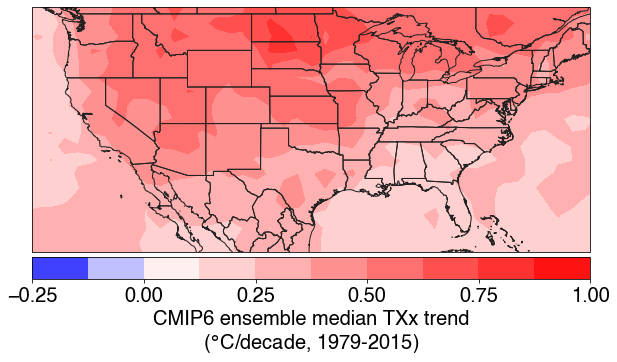

In [480]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(cmip6_txx_trend_global.lon, cmip6_txx_trend_global.lat, cmip6_txx_trend_global.median(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

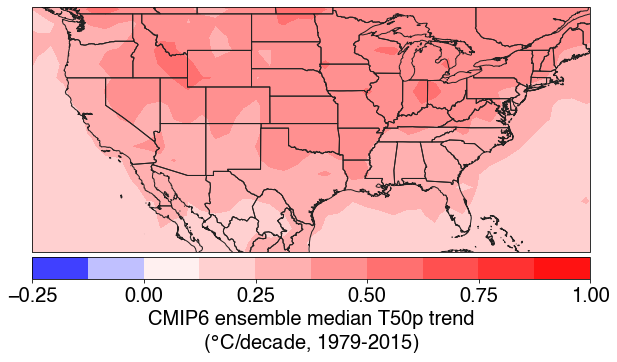

In [419]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(cmip6_t50p_trend_global.lon, cmip6_t50p_trend_global.lat, cmip6_t50p_trend_global.median(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median T50p trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [61]:
# era5_txx = xr.Dataset()
# era5_t50p = xr.Dataset()

# for y, year in enumerate(range(1979, 2014+1)):
#     print('processing era5 %d...'%year)
#     tasmax_era5 = xr.open_dataset('%s/daily/tasmax_%d.nc'%(dirERA5, year))
#     tasmax_era5_us = tasmax_era5.sel(latitude=slice(latRange[1], latRange[0]), \
#                                      longitude=slice(lonRange[0], lonRange[1]))
    
#     txx_era5_us = tasmax_era5_us.max(dim='time')
#     txx_era5_us['mx2t'] -= 273.15
    
#     t50p_era5_us = tasmax_era5_us.median(dim='time')
#     t50p_era5_us['mx2t'] -= 273.15
    
# #     monthly_mean_tx_era5_us = tasmax_era5_us.groupby('time.month').mean()
# #     monthly_mean_tx_era5_us['mx2t'] -= 273.15
    
#     txx_era5_us = txx_era5_us.rename_dims(latitude='lat', longitude='lon')
#     txx_era5_us.load()
    
#     t50p_era5_us = t50p_era5_us.rename_dims(latitude='lat', longitude='lon')
#     t50p_era5_us.load()
    
# #     monthly_mean_tx_era5_us = monthly_mean_tx_era5_us.rename_dims(latitude='lat', longitude='lon')
# #     monthly_mean_tx_era5_us.load()
    
#     regridder = xe.Regridder(txx_era5_us, regridMesh, 'bilinear')
#     regridder.clean_weight_file()
#     txx_era5_us_regrid = regridder(txx_era5_us.mx2t)
#     t50p_era5_us_regrid = regridder(t50p_era5_us.mx2t)
# #     monthly_mean_tx_era5_us_regrid = regridder(monthly_mean_tx_era5_us.mx2t)
    
#     tmpData_txx = np.full([1,txx_era5_us_regrid.values.shape[0], txx_era5_us_regrid.values.shape[1]], np.nan)
#     tmpData_txx[0,:,:] = txx_era5_us_regrid.values
    
#     tmpData_t50p = np.full([1,t50p_era5_us_regrid.values.shape[0], t50p_era5_us_regrid.values.shape[1]], np.nan)
#     tmpData_t50p[0,:,:] = t50p_era5_us_regrid.values
    
# #     tmpData_monthly_mean_tx = np.full([1, monthly_mean_tx_era5_us_regrid.values.shape[1], monthly_mean_tx_era5_us_regrid.values.shape[2]], np.nan)
# #     tmpData_monthly_mean_tx[0,:,:] = monthly_mean_tx_era5_us_regrid.values
    
#     tempDs_txx = xr.Dataset()
#     tempDs_txx['era5_txx'] = xr.DataArray(data   = tmpData_txx, 
#                           dims   = ['time', 'lat', 'lon'],
#                           coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
#                           attrs  = {'units'     : 'C'
#                             })
    
#     tempDs_t50p = xr.Dataset()
#     tempDs_t50p['era5_t50p'] = xr.DataArray(data   = tmpData_t50p, 
#                           dims   = ['time', 'lat', 'lon'],
#                           coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
#                           attrs  = {'units'     : 'C'
#                             })
    
# #     tempDs_monthly_mean_tx = xr.Dataset()
# #     tempDs_monthly_mean_tx['era5_monthly_mean_tx'] = xr.DataArray(data   = tmpData_monthly_mean_tx, 
# #                           dims   = ['time', 'lat', 'lon'],
# #                           coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
# #                           attrs  = {'units'     : 'C'
# #                             })
    
#     if y == 0:
#         era5_txx = tempDs_txx
#         era5_t50p = tempDs_t50p
#     else:
#         era5_txx = xr.concat([era5_txx, tempDs_txx], dim='time')
#         era5_t50p = xr.concat([era5_t50p, tempDs_t50p], dim='time')    

# era5_txx.to_netcdf('era5_txx_us.nc')
# era5_t50p.to_netcdf('era5_t50p_us.nc')

processing era5 1979...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1980...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1981...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1982...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1983...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1984...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1985...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1986...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1987...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
processing era5 1988...
Crea

In [423]:
era5_txx

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 34)
Coordinates:
  * time     (time) datetime64[ns] 1981-12-31 1982-12-31 ... 2014-12-31
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Data variables:
    mx2t     (time, lat, lon) float64 1.54 1.54 1.54 ... -24.44 -24.44 -24.44

In [424]:
era5_txx = xr.open_dataset('era5_txx_us.nc')
era5_txx = era5_txx.rename({'latitude':'lat', 'longitude':'lon'})
# era5_txx = era5_txx.reindex(lat=np.array(list(reversed(era5_txx.lat))))
era5_txx = era5_txx.sel(time=slice('1981', '2014'))

regridder = xe.Regridder(era5_txx, regridMesh, 'bilinear')
regridder.clean_weight_file()
era5_txx_regrid = regridder(era5_txx)

era5_t50p = xr.open_dataset('era5_t50p_us.nc')
era5_t50p = era5_t50p.rename({'latitude':'lat', 'longitude':'lon'})
# era5_t50p = era5_t50p.reindex(lat=np.array(list(reversed(era5_t50p.lat))))
era5_t50p = era5_t50p.sel(time=slice('1981', '2014'))

regridder = xe.Regridder(era5_t50p, regridMesh, 'bilinear')
regridder.clean_weight_file()
era5_t50p_regrid = regridder(era5_t50p)

Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
using dimensions ('lat', 'lon') from data variable mx2t as the horizontal dimensions for this dataset.
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc
using dimensions ('lat', 'lon') from data variable mx2t as the horizontal dimensions for this dataset.


In [425]:
# calc era5 txx and t50p trends
era5_txx_trend = xr.Dataset()
era5_t50p_trend = xr.Dataset()

print('calc era5 txx and t50p trends')
tmpTxxTrend = np.full([era5_txx_regrid.lat.values.shape[0], era5_txx_regrid.lon.values.shape[0]], np.nan)
tmpT50pTrend = np.full([era5_t50p_regrid.lat.values.shape[0], era5_t50p_regrid.lon.values.shape[0]], np.nan)

for xlat in range(tmpTxxTrend.shape[0]):
    for ylon in range(tmpTxxTrend.shape[1]):
        curTxx = era5_txx_regrid.mx2t.values[:, xlat, ylon]
        X = sm.add_constant(range(1981, 2014+1))
        mdl = sm.OLS(curTxx, X).fit()
        tmpTxxTrend[xlat, ylon] = mdl.params[1]*10
        
        curT50p = era5_t50p_regrid.mx2t.values[:, xlat, ylon]
        X = sm.add_constant(range(1981, 2014+1))
        mdl = sm.OLS(curT50p, X).fit()
        tmpT50pTrend[xlat, ylon] = mdl.params[1]*10

era5_txx_trend['txx_trend'] = xr.DataArray(data   = tmpTxxTrend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_txx_regrid.lat, 'lon':era5_txx_regrid.lon},
                  attrs  = {'units'     : 'C'
                    })

era5_t50p_trend['t50p_trend'] = xr.DataArray(data   = tmpT50pTrend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_t50p_regrid.lat, 'lon':era5_t50p_regrid.lon},
                  attrs  = {'units'     : 'C'
                    })


calc era5 txx and t50p trends


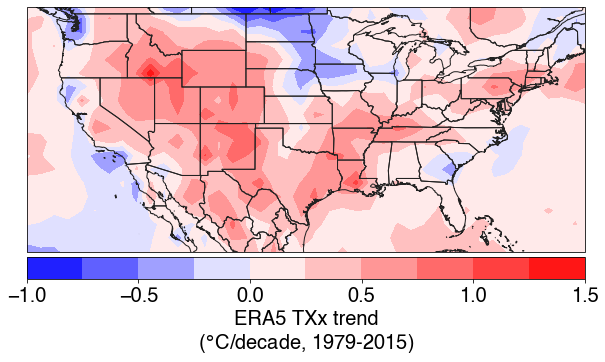

In [426]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, era5_txx_trend.txx_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

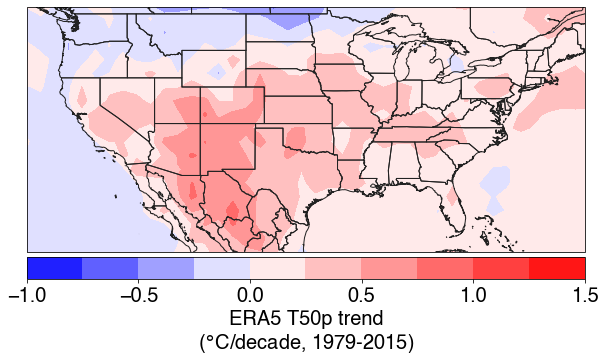

In [427]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, era5_t50p_trend.t50p_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 T50p trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [430]:
cmip6_txx_trend

<xarray.Dataset>
Dimensions:                        (lat: 24, lon: 54, model: 21)
Coordinates:
  * lat                            (lat) float64 20.0 21.5 23.0 ... 53.0 54.5
  * lon                            (lon) float64 220.0 221.5 ... 298.0 299.5
  * model                          (model) object 'access-cm2' ... 'sam0-unicon'
Data variables:
    __xarray_dataarray_variable__  (model, lat, lon) float64 ...

In [428]:
# calculate trend bias between cmip6 and era5

cmip6_era5_txx_trend_bias_sig = np.full(era5_txx_trend.txx_trend.shape, np.nan)
cmip6_era5_txx_trend_bias = np.full([len(cmip6_models), era5_txx_trend.txx_trend.shape[0], era5_txx_trend.txx_trend.shape[1]], np.nan)

for m, model in enumerate(cmip6_models):
    cmip6_era5_txx_trend_bias[m,:,:] = cmip6_txx_trend[m,:,:] - era5_txx_trend.txx_trend.values

for xlat in range(cmip6_era5_txx_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_txx_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_txx_trend_bias[:, xlat, ylon], 0)
        cmip6_era5_txx_trend_bias_sig[xlat, ylon] = p

        
cmip6_era5_t50p_trend_bias_sig = np.full(era5_t50p_trend.t50p_trend.shape, np.nan)
cmip6_era5_t50p_trend_bias = np.full([len(cmip6_models), era5_t50p_trend.t50p_trend.shape[0], era5_t50p_trend.t50p_trend.shape[1]], np.nan)

for m, model in enumerate(cmip6_models):
    cmip6_era5_t50p_trend_bias[m,:,:] = cmip6_t50p_trend[m,:,:] - era5_t50p_trend.t50p_trend.values

for xlat in range(cmip6_era5_t50p_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_t50p_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_t50p_trend_bias[:, xlat, ylon], 0)
        cmip6_era5_t50p_trend_bias_sig[xlat, ylon] = p

KeyError: 0

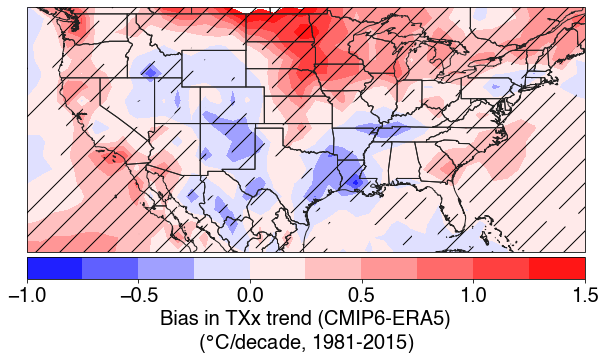

In [372]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, np.nanmedian(cmip6_era5_txx_trend_bias, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, cmip6_era5_txx_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in TXx trend (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

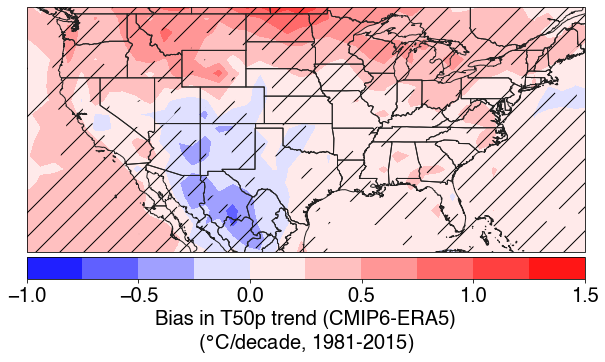

In [373]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(cmip6_era5_t50p_trend_bias, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, cmip6_era5_txx_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in T50p trend (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [374]:
# calc bias by year
recalc = False
if os.path.isfile('yearly-cmip6-era5-txx-bias.dat') and not recalc:
    with open('yearly-cmip6-era5-txx-bias.dat', 'rb') as f:
        yearly_txx_bias = pickle.load(f)
    with open('yearly-cmip6-era5-t50p-bias.dat', 'rb') as f:
        yearly_t50p_bias = pickle.load(f)
else:
    yearly_txx_bias = np.full([len(cmip6_models), era5_txx_regrid.time.values.shape[0], era5_txx_regrid.lat.values.shape[0], era5_txx_regrid.lon.values.shape[0]], np.nan)
    yearly_t50p_bias = np.full([len(cmip6_models), era5_t50p_regrid.time.values.shape[0], era5_t50p_regrid.lat.values.shape[0], era5_t50p_regrid.lon.values.shape[0]], np.nan)

    for m, model in enumerate(cmip6_models):
        print('processing %s...'%model)
        for y, year in enumerate(range(1981, 2014+1)):
            for xlat in range(yearly_txx_bias.shape[2]):
                for ylon in range(yearly_txx_bias.shape[3]):
                    yearly_txx_bias[m, y, xlat, ylon] = cmip6_txx_regrid.txx.values[m, y, xlat, ylon] - era5_txx_regrid.mx2t.values[y, xlat, ylon]
                    yearly_t50p_bias[m, y, xlat, ylon] = cmip6_t50p_regrid.t50p.values[m, y, xlat, ylon] - era5_t50p_regrid.mx2t.values[y, xlat, ylon]
    
    with open('yearly-cmip6-era5-txx-bias.dat', 'wb') as f:
        pickle.dump(yearly_txx_bias, f)
    with open('yearly-cmip6-era5-t50p-bias.dat', 'wb') as f:
        pickle.dump(yearly_t50p_bias, f)

processing access-cm2...
processing access-esm1-5...
processing awi-cm-1-1-mr...
processing bcc-csm2-mr...
processing bcc-esm1...
processing canesm5...
processing ec-earth3...
processing gfdl-cm4...
processing gfdl-esm4...
processing giss-e2-1-g...
processing kace-1-0-g...
processing fgoals-g3...
processing inm-cm5-0...
processing ipsl-cm6a-lr...
processing miroc6...
processing mpi-esm1-2-hr...
processing mpi-esm1-2-lr...
processing mri-esm2-0...
processing noresm2-lm...
processing noresm2-mm...
processing sam0-unicon...


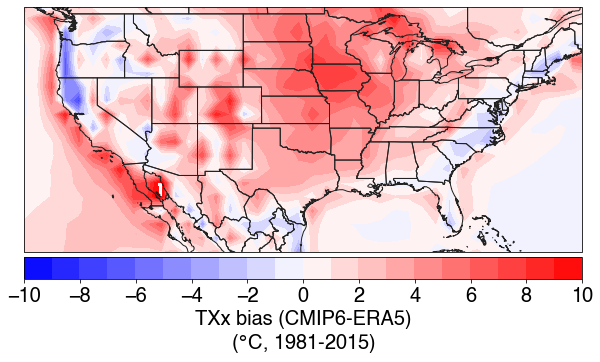

In [376]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, np.nanmedian(np.nanmean(yearly_txx_bias, axis=1), axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('TXx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

In [19]:
latInd = np.where((era5_txx.lat.values >= 41.5) & (era5_txx.lat.values <= 48))[0]
lonInd = np.where((era5_txx.lon.values >= 263) & (era5_txx.lon.values <= 270))[0]

yearly_txx_bias_midwest = yearly_txx_bias[latInd, :, :, :]
yearly_txx_bias_midwest = np.nanmean(np.nanmean(yearly_txx_bias_midwest[:, lonInd, :, :], axis=1), axis=0)

yearly_t50p_bias_midwest = yearly_t50p_bias[latInd, :, :, :]
yearly_t50p_bias_midwest = np.nanmean(np.nanmean(yearly_t50p_bias_midwest[:, lonInd, :, :], axis=1), axis=0)
# plt.plot(np.nanmedian(yearly_txx_bias_midwest, axis=1))

In [20]:
X = sm.add_constant(range(1979, 2015))
mdl = sm.RLM(np.nanmedian(yearly_txx_bias_midwest, axis=1), X).fit()
print('txx: coef = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))

X = sm.add_constant(range(1979, 2015))
mdl = sm.RLM(np.nanmedian(yearly_t50p_bias_midwest, axis=1), X).fit()
print('t50p: coef = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))

txx: coef = 0.06, p = 0.08
t50p: coef = 0.03, p = 0.04


In [21]:
for m in range(len(cmip6_models)):
    X = sm.add_constant(range(1979, 2015))
    mdl = sm.RLM(yearly_txx_bias_midwest[:,m], X).fit()
    print('coef = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))

coef = 0.04, p = 0.38
coef = 0.06, p = 0.22
coef = 0.06, p = 0.11
coef = 0.03, p = 0.34
coef = 0.04, p = 0.49
coef = 0.02, p = 0.69
coef = 0.06, p = 0.16
coef = 0.06, p = 0.11
coef = 0.05, p = 0.23
coef = -0.02, p = 0.51
coef = 0.02, p = 0.54
coef = 0.06, p = 0.17
coef = -0.03, p = 0.45
coef = 0.10, p = 0.02
coef = 0.06, p = 0.10
coef = -0.00, p = 0.92
coef = -0.01, p = 0.81
coef = 0.01, p = 0.88
coef = 0.05, p = 0.22
coef = 0.08, p = 0.02
coef = 0.08, p = 0.10


In [379]:
recalc = False
if os.path.isfile('yearly-cmip6-era5-bias-trend.dat') and not recalc:
    print('loading precomputed bias trend...')
    with open('yearly-cmip6-era5-bias-trend.dat', 'rb') as f:
        f = pickle.load(f)
        yearly_txx_bias_trend = f['yearly_txx_bias_trend']
        yearly_txx_bias_trend_sig = f['yearly_txx_bias_trend_sig']
        yearly_t50p_bias_trend = f['yearly_t50p_bias_trend']
        yearly_t50p_bias_trend_sig = f['yearly_t50p_bias_trend_sig']

else:
    yearly_txx_bias_trend = np.full([len(cmip6_models), yearly_txx_bias.shape[2], yearly_txx_bias.shape[3]], np.nan)
    yearly_txx_bias_trend_sig = np.full([len(cmip6_models), yearly_txx_bias.shape[2], yearly_txx_bias.shape[3]], np.nan)

    yearly_t50p_bias_trend = np.full([len(cmip6_models), yearly_t50p_bias.shape[2], yearly_t50p_bias.shape[3]], np.nan)
    yearly_t50p_bias_trend_sig = np.full([len(cmip6_models), yearly_t50p_bias.shape[2], yearly_t50p_bias.shape[3]], np.nan)

    for m in range(len(cmip6_models)):
        print('processing %s...'%cmip6_models[m])
        for xlat in range(yearly_txx_bias_trend.shape[1]):
            for ylon in range(yearly_txx_bias_trend.shape[2]):
                curBias = np.squeeze(yearly_txx_bias[m, :, xlat, ylon])
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.RLM(curBias, X).fit()
                yearly_txx_bias_trend[m, xlat, ylon] = mdl.params[1]*10
                yearly_txx_bias_trend_sig[m, xlat, ylon] = mdl.pvalues[1]

                curBias = np.squeeze(yearly_t50p_bias[m, :, xlat, ylon])
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.RLM(curBias, X).fit()
                yearly_t50p_bias_trend[m, xlat, ylon] = mdl.params[1]*10
                yearly_t50p_bias_trend_sig[m, xlat, ylon] = mdl.pvalues[1]

    with open('yearly-cmip6-era5-bias-trend.dat', 'wb') as f:
        pickle.dump({'yearly_txx_bias_trend': yearly_txx_bias_trend,
                     'yearly_txx_bias_trend_sig':yearly_txx_bias_trend_sig,
                     'yearly_t50p_bias_trend':yearly_t50p_bias_trend,
                     'yearly_t50p_bias_trend_sig':yearly_t50p_bias_trend_sig}, f)

loading precomputed bias trend...


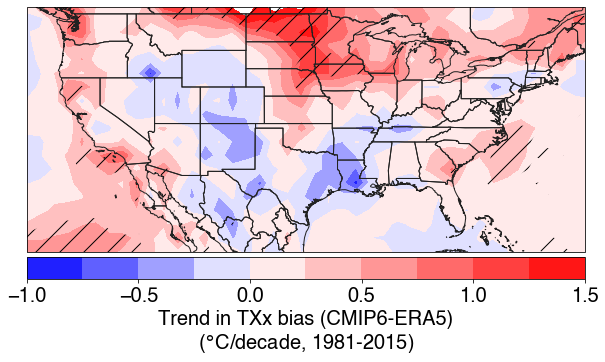

In [386]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, np.nanmedian(yearly_txx_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, np.nanmedian(yearly_txx_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in TXx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

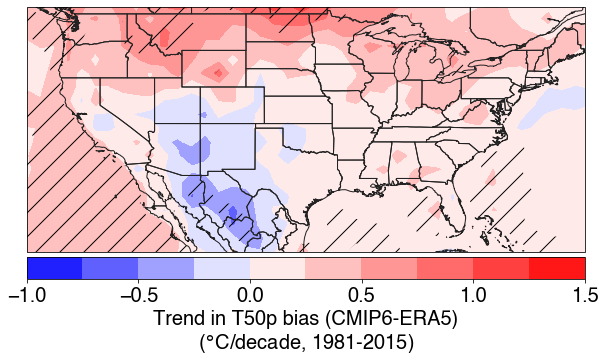

In [288]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in T50p bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [387]:
# load cropped area data

ca_year = 2005

with open('maize_hw_%d_regrid.dat'%ca_year, 'rb') as f:
    maize_ha_regrid_era5 = pickle.load(f)

regridder = xe.Regridder(xr.DataArray(data=maize_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh, 'bilinear')
regridder.clean_weight_file()
maize_ha_regrid_15_us = regridder(maize_ha_regrid_era5)


Create weight file: bilinear_721x1440_24x54.nc
Remove file bilinear_721x1440_24x54.nc


In [388]:
maize_ha_regrid_15_us_1d = np.reshape(maize_ha_regrid_15_us, [maize_ha_regrid_15_us.size,1])

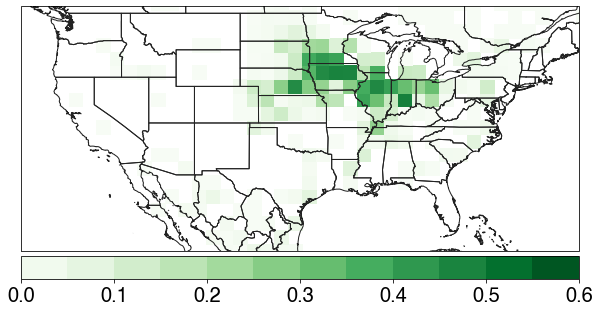

In [389]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = 0
v2 = .61
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(era5_t50p_trend.lon, era5_t50p_trend.lat, maize_ha_regrid_15_us, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in T50p bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [390]:
for myearly_txx_bias.shape

(21, 34, 24, 54)

In [324]:
# load deepak data

if not os.path.isfile('deepak_maize.nc'):
    maize_yield_deepak_ds = xr.Dataset()
    for y, year in enumerate(range(1979, 2013+1)):
        print('processing deepak for %d...'%year)
        cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_maize_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_maize_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_maize_yield_deepak_ds['latitude'].values
        cur_maize_yield_deepak_ds['latitude'] = latvals

        cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_maize_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

        tempDs_maize_yield = xr.Dataset()
        tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            maize_yield_deepak_ds = tempDs_maize_yield
        else:
            maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')
    maize_yield_deepak_ds.to_netcdf('deepak_maize.nc')
else:
    maize_yield_deepak_ds = xr.open_dataset('deepak_maize.nc')

In [292]:
maize_yield_deepak_trend = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)

for xlat in range(maize_yield_deepak_trend.shape[0]):
    for ylon in range(maize_yield_deepak_trend.shape[1]):
        curY = maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            maize_yield_deepak_trend[xlat, ylon] = mdl.params[1]


In [298]:
# yearly_txx_bias_trend
cmip6_txx_bias = cmip6_txx_trend_median-era5_txx_trend.txx_trend.values
cmip6_t50p_bias = cmip6_t50p_trend_median-era5_t50p_trend.t50p_trend.values
maize_yield = np.nanmean(maize_yield_deepak_ds.maize_yield.values, axis=0)

In [299]:
yearly_txx_bias_trend_median = np.nanmedian(yearly_txx_bias_trend, axis=0)
yearly_txx_bias_median = np.nanmean(np.nanmedian(yearly_txx_bias, axis=0), axis=0)

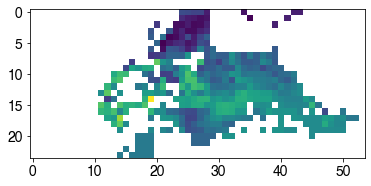

In [305]:
plt.imshow(maize_yield)

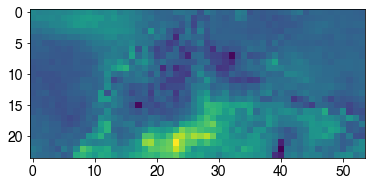

In [326]:
plt.imshow(yearly_txx_bias_trend_median)

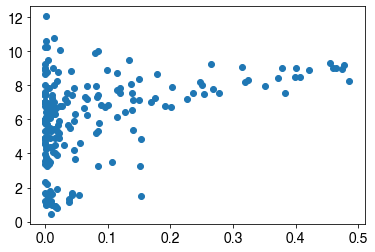

In [332]:
plt.scatter(maize_ha_regrid_15_us_1d,maize_yield_1d)

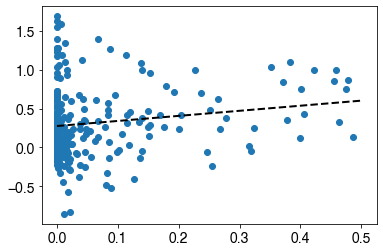

In [338]:
maize_yield_1d = maize_yield.reshape([maize_yield.size, 1])
maize_yield_deepak_trend_1d = maize_yield_deepak_trend.reshape([maize_yield_deepak_trend.size, 1])
yearly_txx_bias_trend_median_1d = yearly_txx_bias_trend_median.reshape([yearly_txx_bias_trend_median.size, 1])
yearly_txx_bias_median_1d = yearly_txx_bias_median.reshape([yearly_txx_bias_median.size, 1])

nn_txx = np.where((~np.isnan(maize_ha_regrid_15_us_1d)) & (~np.isnan(yearly_txx_bias_trend_median_1d)))[0]
# nn_t50p = np.where((~np.isnan(maize_yield_1d)) & (~np.isnan(cmip6_t50p_bias_1d)))[0]

X = sm.add_constant(maize_ha_regrid_15_us_1d[nn_txx])
mdl_txx = sm.OLS(yearly_txx_bias_trend_median_1d[nn_txx], X).fit()

# X = sm.add_constant(maize_yield_1d[nn_t50p])
# mdl_t50p = sm.OLS(cmip6_t50p_bias_1d[nn_t50p], X).fit()

# fig, ax = plt.subplots(1,1,figsize=(12,6))

x1 = 0
x2 = .5
plt.scatter(maize_ha_regrid_15_us_1d[nn_txx], yearly_txx_bias_trend_median_1d[nn_txx])
plt.plot([x1, x2], [mdl_txx.params[0]+x1*mdl_txx.params[1], mdl_txx.params[0]+x2*mdl_txx.params[1]], '--k', lw=2)

# x1 = 0
# x2 = 10
# ax[1].scatter(maize_yield_1d[nn_t50p], cmip6_t50p_bias_1d[nn_t50p])
# ax[1].plot([x1, x2], [mdl_t50p.params[0]+x1*mdl_t50p.params[1], mdl_t50p.params[0]+x2*mdl_t50p.params[1]], '--k', lw=2)

In [391]:
yearly_txx_bias.shape

(21, 34, 24, 54)

In [392]:
yearly_txx_bias_mean = np.nanmean(yearly_txx_bias, axis=1)
yearly_t50p_bias_mean = np.nanmean(yearly_t50p_bias, axis=1)

In [395]:
for m in range(len(cmip6_models)):
    yearly_txx_bias_mean_1d = np.reshape(yearly_txx_bias_mean[m,:,:], [yearly_txx_bias_mean[m,:,:].size, 1])
    yearly_t50p_bias_mean_1d = np.reshape(yearly_t50p_bias_mean[m,:,:], [yearly_t50p_bias_mean[m,:,:].size, 1])
    
    nn = np.where((~np.isnan(maize_ha_regrid_15_us_1d)) & (~np.isnan(yearly_txx_bias_mean_1d)))[0]
    
    X = sm.add_constant(maize_ha_regrid_15_us_1d[nn])
    mdl = sm.RLM(yearly_txx_bias_mean_1d[nn], X).fit()
    
    print('%.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))
    

8.43, p = 0.00
14.97, p = 0.00
11.46, p = 0.00
17.66, p = 0.00
16.62, p = 0.00
11.65, p = 0.00
0.72, p = 0.46
0.31, p = 0.77
2.25, p = 0.08
-0.03, p = 0.98
18.54, p = 0.00
10.88, p = 0.00
21.04, p = 0.00
11.14, p = 0.00
5.59, p = 0.00
4.61, p = 0.00
4.05, p = 0.00
4.55, p = 0.00
12.11, p = 0.00
14.06, p = 0.00
12.71, p = 0.00


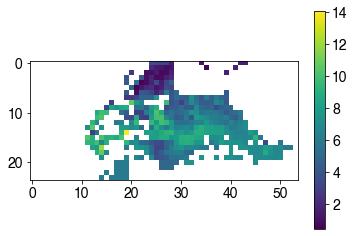

In [316]:
plt.imshow(maize_yield); plt.colorbar()

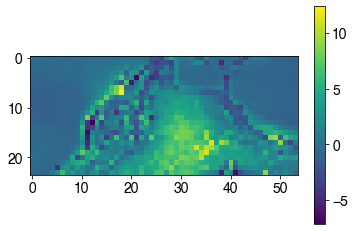

In [317]:
plt.imshow(yearly_txx_bias_mean[m,:,:]); plt.colorbar()

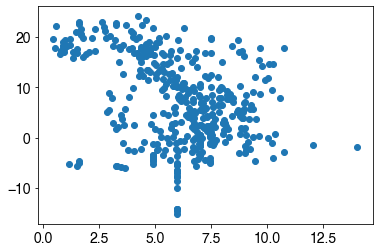

In [160]:
m = 5
yearly_t50p_bias_mean_1d = np.reshape(yearly_t50p_bias_mean[:,:,m], [yearly_t50p_bias_mean[:,:,m].size, 1])
nn = np.where((~np.isnan(maize_yield_1d)) & (~np.isnan(yearly_t50p_bias_mean_1d)))[0]
plt.scatter(maize_yield_1d[nn], yearly_t50p_bias_mean_1d[nn])

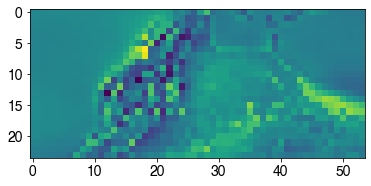

In [318]:
plt.imshow(yearly_t50p_bias_mean[m,:,:])

In [319]:
X = sm.add_constant(maize_yield_1d[nn])
mdl = sm.RLM(yearly_txx_bias_mean_1d[nn], X).fit()
mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                      y   No. Observations:                  417
Model:                            RLM   Df Residuals:                      415
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 25 Mar 2021                                         
Time:                        13:17:07                                         
No. Iterations:                    12                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0754      0.456     -0.165      0.869      -0.969       0.818
x1             0.3460      0.070      4.908      0.000       0.208       0.484
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

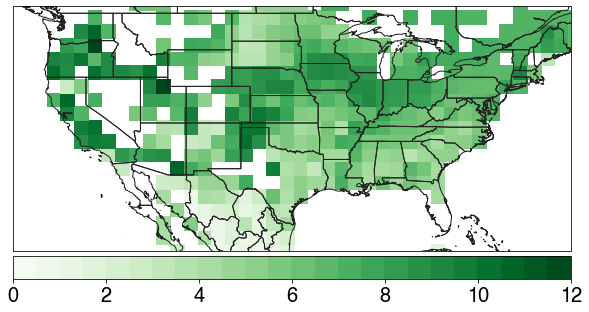

In [351]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = 0
v2 = 12.01
vstep = .5
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(maize_yield_deepak_ds.lon, maize_yield_deepak_ds.lat, np.nanmean(maize_yield_deepak_ds.maize_yield.values, axis=0), cmap=cmap, norm=midnorm)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in T50p bias (CMIP6-ERA5)\n($\degree$C/decade, 1979-2015)', fontsize=20)